NLP PREPROCESSING FOR YELP AND AMAZON REVIEWS

In [1]:
# This time we'll use Long Short-Term Memories (LSTMs) to try to get better results
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

path = 'https://raw.githubusercontent.com/AleGL92/TensorFlow/main/NLP/combined_data.csv'
ds = pd.read_csv(path)
print(ds.head())

sentences = ds['text'].tolist()
labels = ds['sentiment'].tolist()

   Unnamed: 0                                               text  sentiment
0           0  So there is no way for me to plug it in here i...          0
1           1                         Good case Excellent value.          1
2           2                             Great for the jawbone.          1
3           3  Tied to charger for conversations lasting more...          0
4           4                                  The mic is great.          1


1. Create a subword dataset

In [2]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)
# SubwordTextEncoder.build_from_corpus() will create a tokenizer with the 1000 most common subwords, after cutting 
# each word into subwords, having at most 5 characters.
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [3]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

# Separately print out each subword, decoded
for i in encoded:
    print(tokenizer.decode([i]))


I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


In [4]:
# Now we create the sequences that will be used for training. This is the same as using the text_to_sequences command that
# we used in the previous code.
for i, sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)

# And finally, we pad the sequences to have them all with the same length and split into train and test sets.
max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

2. Create the model

In [5]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# model.summary()

num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))
# In the last epoch we got val_accuracy: 0.7469 wich appears to be good.

Epoch 1/30
50/50 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.5700 - val_loss: 0.6902 - val_accuracy: 0.6942
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6873 - accuracy: 0.6755 - val_loss: 0.6846 - val_accuracy: 0.7243
Epoch 3/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.7062 - val_loss: 0.6833 - val_accuracy: 0.5614
Epoch 4/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6670 - accuracy: 0.7125 - val_loss: 0.6703 - val_accuracy: 0.6717
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6492 - accuracy: 0.7489 - val_loss: 0.6567 - val_accuracy: 0.6967
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.7790 - val_loss: 0.6337 - val_accuracy: 0.7519
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.8060 - val_loss: 0.6193 - val_accuracy: 0.7393
Epoch 8/30
50/50 [==

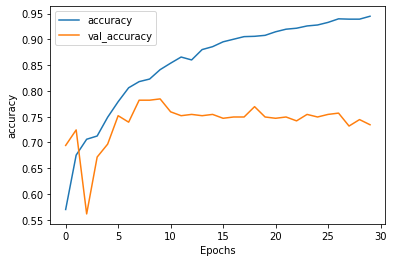

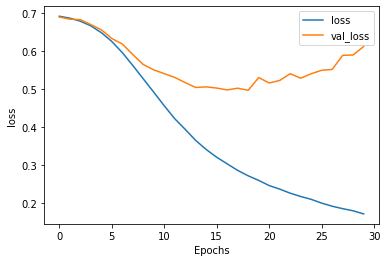

In [6]:
# Plotting the accuracy and loss. This is a very easy method to plot them.
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
# Accuracy keeps going up with more epochs, but it's actually the same from epoch 15 and on, as we
# can see in the val_accuracy line.
# The loss is supposed to get smaller with more epochs, but it gets the best value, also around 15 epochs
# from where it starts growing again.

2. Create functions for having the model and the sentences as an input

In [7]:
# To test different models with new reviews, we are creating a function that takes as input
# both model and reviews. This will make it easier to compare.

def predict_review(model, new_sentences, maxlen = max_length, show_padded_sequence = True):
    # Keep the original sentences so that we can keep using them later
    # Create an array to hold the encoded sequences
    new_sequences = []

    # Convert the new reviews to sequences
    for i, frvw in enumerate(new_sentences):
        new_sequences.append(tokenizer.encode(frvw))

    trunc_type='post' 
    padding_type='post'

    # Pad all sequences for the new reviews
    new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                    padding=padding_type, truncating=trunc_type)             

    classes = model.predict(new_reviews_padded)

    # The closer the class is to 1, the more positive the review is
    for x in range(len(new_sentences)):
        # We can see the padded sequence if desired
        # Print the sequence
        if (show_padded_sequence):
            print(new_reviews_padded[x])
        # Print the review as text
        print(new_sentences[x])
        # Print its predicted class
        print(classes[x])
        print("\n")

In [8]:
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
]
predict_review(model, fake_reviews)
# We don't see the reviews separated as subwords, because that was used just for training the model

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.92816544]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.12308329]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.3434775]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.11093381]


[  1 109 228 540 237 635 24

In [9]:
# In the same direction as the previous lines, we'll define a function that takes the model, 
# compiles it, trains it and graphs the accuracy and loss, so that we can compare results
def fit_model_now (model, sentences) :
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                        validation_data=(testing_sequences, testing_labels_final))
    return history

def plot_results (history):
    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
    history = fit_model_now(model, sentences)
    plot_results(history)
    predict_review(model, sentences)

3. Add a bidirectional LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 5s 29ms/step - loss: 0.6918 - accuracy: 0.5041 - val_loss: 0.701

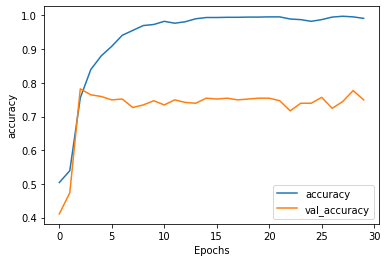

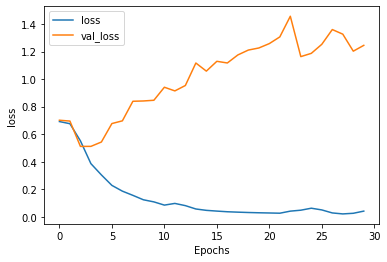

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99825525]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.029147]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.9925528]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.07416338]


[  1 109 228 540 237 635 241 

In [10]:
# Define the model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)

4. Add multiple biderectional layers (2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 198       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 26,701
Trainable params: 26,701
Non-trai

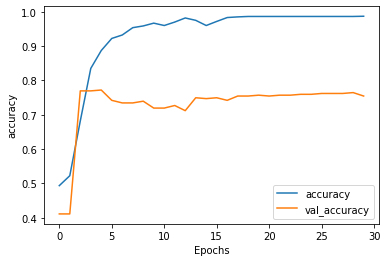

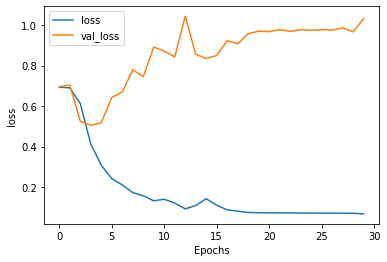

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9943634]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01778185]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.02609065]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.01712993]


[  1 109 228 540 237 635 24

In [11]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                    return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

5. Comparing the predictions for the previous models

In [12]:
# We will compare the results for the three models:
#   - Embeddings and a Global Average Pooling layer
#   - Embeddings and a Bidirectional LSTM layer
#   - Embeddings and 2 Birectional LSTM layers

my_reviews =["lovely", "dreadful", "stay away",
            "everything was hot exactly as I wanted",
            "everything was not exactly as I wanted",
            "they gave us free chocolate cake",
            "I've never eaten anything so spicy in my life, my throat burned for hours",
            "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
            "we left there very full for a low price so I'd say you just can't go wrong at this place",
            "that place does not have quality meals and it isn't a good place to go for dinner",
            ]

In [13]:
print("Embeddings and Global Average Pooling layer:\n")
predict_review(model, my_reviews, show_padded_sequence=False)

Embeddings and Global Average Pooling layer:

lovely
[0.94326764]


dreadful
[0.34654933]


stay away
[0.6966634]


everything was hot exactly as I wanted
[0.77050877]


everything was not exactly as I wanted
[0.5518987]


they gave us free chocolate cake
[0.7565109]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02312931]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.63400745]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.8064456]


that place does not have quality meals and it isn't a good place to go for dinner
[0.86883605]




In [14]:
print("Embeddings and Bidirectional LSTM layer:\n")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

Embeddings and Bidirectional LSTM layer:

lovely
[0.9835808]


dreadful
[0.00897285]


stay away
[0.01279053]


everything was hot exactly as I wanted
[0.9987343]


everything was not exactly as I wanted
[0.34681556]


they gave us free chocolate cake
[0.9956]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.00376588]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.97715986]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9999682]


that place does not have quality meals and it isn't a good place to go for dinner
[0.0056493]




In [15]:
print("Embeddings and 2 Bidirectional LSTM layers:\n")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

Embeddings and 2 Bidirectional LSTM layers:

lovely
[0.99442333]


dreadful
[0.01494637]


stay away
[0.04431921]


everything was hot exactly as I wanted
[0.05246297]


everything was not exactly as I wanted
[0.01562929]


they gave us free chocolate cake
[0.9890133]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01451507]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.01561949]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.01654321]


that place does not have quality meals and it isn't a good place to go for dinner
[0.6197384]


